# Reading Hydro echo files into Pandas DataFrame

hydro (and qual) compile the input files and output an echo file that contains all the input data that goes into the model run. This is a very useful file as it is a direct representation of the input as seen by the model. This is especially important as the input system with its layering and overrides and include featues can be quite complex and sometimes it can be hard to see what actually finally make it into the model run.

To create an echo file of the inputs, refer to hydro and qual document. Below is an example 

```
 hydro -e hydro_main.inp 
  
 qual -e qual_main.inp
```

The notebook here shows how to use the pydsm parser to read this echo file into a dictionary of pandas DataFrame objects


In [1]:
import pandas as pd
import io
import re
# main import 
import pydsm
from pydsm.input import read_input,write_input

## Read input into a dictionary of pandas DataFrames

DSM2 input consists of tables that have a name, e.g. CHANNEL. They have named columns and then rows of values for those columns

```
CHANNEL
CHAN_NO LENGTH MANNING DISPERSION UPNODE DOWNNODE
0	1	19500	0.035	360.0	1	2
1	2	14000	0.028	360.0	2	3
...
END
```

The *read_input* method reads the input file, parsing the tables found into data frames and returning a dictionary the keys of which are the names of the tables

Lets see how this looks...

In [2]:
fname='../../tests/hydro_echo_historical_v82.inp'
tables=read_input(fname)

## Print list of all tables

In [3]:
print(list(tables.keys()))

['ENVVAR', 'SCALAR', 'IO_FILE', 'CHANNEL', 'XSECT', 'XSECT_LAYER', 'RESERVOIR', 'RESERVOIR_VOL', 'RESERVOIR_CONNECTION', 'GATE', 'GATE_WEIR_DEVICE', 'GATE_PIPE_DEVICE', 'TRANSFER', 'CHANNEL_IC', 'RESERVOIR_IC', 'BOUNDARY_STAGE', 'BOUNDARY_FLOW', 'SOURCE_FLOW', 'SOURCE_FLOW_RESERVOIR', 'INPUT_GATE', 'INPUT_TRANSFER_FLOW', 'OPERATING_RULE', 'OPRULE_EXPRESSION', 'OPRULE_TIME_SERIES', 'OUTPUT_CHANNEL', 'OUTPUT_RESERVOIR', 'OUTPUT_GATE']


## Display the DataFrame for a table, e.g. CHANNEL

In [4]:
display(tables['CHANNEL'])

,CHAN_NO,LENGTH,MANNING,DISPERSION,UPNODE,DOWNNODE
0,1,19500,0.035,360.0,1,2
1,2,14000,0.028,360.0,2,3
2,3,13000,0.028,360.0,3,4
3,4,14050,0.028,360.0,4,5
4,5,12350,0.028,360.0,5,6
...,...,...,...,...,...,...
516,575,13000,0.022,1800.0,328,357
517,700,10000,0.033,360.0,700,330
518,701,10000,0.033,360.0,701,700
519,702,10000,0.033,360.0,702,701


It is a data frame so you can query its types, etc just like a pandas DataFrame

In [5]:
print(tables['CHANNEL'].dtypes)

CHAN_NO         int64
LENGTH          int64
MANNING       float64
DISPERSION    float64
UPNODE          int64
DOWNNODE        int64
dtype: object


## Programmatic inspection of input
This is an important feature as pandas has a multitude of features to allow for filtering, describing and joining with other DataFrames and this can be used to analyze the input file

For example, display all channels with length > 20000 feet

In [6]:
c=tables['CHANNEL']
print('Channels with length > 20000 ft:')
display(c[c.LENGTH>20000])

Channels with length > 20000 ft:


,CHAN_NO,LENGTH,MANNING,DISPERSION,UPNODE,DOWNNODE
372,392,23897,0.022,360.0,310,311
374,394,21261,0.022,360.0,312,313
376,396,24303,0.022,360.0,314,315
378,398,21353,0.024,360.0,316,350
381,401,25700,0.022,360.0,319,321
394,414,24177,0.028,360.0,334,335
396,416,25418,0.028,360.0,336,337
413,434,20141,0.019,920.0,353,354
416,437,20200,0.022,740.0,356,357
461,484,21700,0.021,1200.0,400,372


## Combining input tables
Channels have cross sections but those are defined in the 'XSECT_LAYER' table. 


In [7]:
x=tables['XSECT_LAYER']
display(x)

,CHAN_NO,DIST,ELEV,AREA,WIDTH,WET_PERIM
0,1,0.240,4.225,0.0,0.0,0.0
1,1,0.240,5.995,103.6,116.4,116.5
2,1,0.240,27.715,10088.4,803.1,805.2
3,1,0.240,35.345,16724.9,936.8,939.9
4,1,0.240,38.475,19710.7,970.3,973.6
...,...,...,...,...,...,...
10888,703,0.875,30.720,19208.3,574.4,594.2
10889,703,0.875,30.920,19331.5,682.7,702.5
10890,703,0.875,35.030,22292.8,755.6,776.7
10891,703,0.875,41.900,27735.4,830.4,854.0


These can be combined (merged) with the channel table on the 'CHAN_NO' common column to get a larger table with channel and x section information

In [8]:
fc=pd.merge(c,x,on='CHAN_NO')
for name, group in fc[fc.CHAN_NO==441].groupby('DIST'):
    print('DIST: ',name)
    display(group)

DIST:  0.006999999999999999


,CHAN_NO,LENGTH,MANNING,DISPERSION,UPNODE,DOWNNODE,DIST,ELEV,AREA,WIDTH,WET_PERIM
8597,441,5398,0.022,1800.0,360,361,0.007,-69.571,0.0,0.0,0.0
8598,441,5398,0.022,1800.0,360,361,0.007,-50.761,15009.5,1595.8,1596.3
8599,441,5398,0.022,1800.0,360,361,0.007,-48.121,19423.5,1749.7,1750.2
8600,441,5398,0.022,1800.0,360,361,0.007,-38.601,45235.5,3673.7,3674.9
8601,441,5398,0.022,1800.0,360,361,0.007,-29.411,81225.1,4158.2,4159.8
8602,441,5398,0.022,1800.0,360,361,0.007,11.588,271505.0,5122.2,5127.5
8603,441,5398,0.022,1800.0,360,361,0.007,13.448,281078.4,5149.9,5155.3


DIST:  0.496


,CHAN_NO,LENGTH,MANNING,DISPERSION,UPNODE,DOWNNODE,DIST,ELEV,AREA,WIDTH,WET_PERIM
8604,441,5398,0.022,1800.0,360,361,0.496,-57.738,0.0,0.0,0.0
8605,441,5398,0.022,1800.0,360,361,0.496,-45.738,17399.2,2898.0,2898.1
8606,441,5398,0.022,1800.0,360,361,0.496,-44.338,21506.8,2989.5,2989.8
8607,441,5398,0.022,1800.0,360,361,0.496,-37.828,43278.8,3697.5,3698.5
8608,441,5398,0.022,1800.0,360,361,0.496,17.441,277685.2,4783.9,4790.7
8609,441,5398,0.022,1800.0,360,361,0.496,20.471,292255.5,4808.1,4815.2


DIST:  0.914


,CHAN_NO,LENGTH,MANNING,DISPERSION,UPNODE,DOWNNODE,DIST,ELEV,AREA,WIDTH,WET_PERIM
8610,441,5398,0.022,1800.0,360,361,0.914,-52.325,0.0,0.0,0.0
8611,441,5398,0.022,1800.0,360,361,0.914,-50.835,1095.4,1472.0,1472.0
8612,441,5398,0.022,1800.0,360,361,0.914,-43.025,16536.4,2480.1,2480.4
8613,441,5398,0.022,1800.0,360,361,0.914,-42.835,17065.9,3211.0,3211.3
8614,441,5398,0.022,1800.0,360,361,0.914,14.614,254820.8,5063.7,5067.6
8615,441,5398,0.022,1800.0,360,361,0.914,17.244,268182.3,5115.0,5119.1


# Visualizing input data
Furthermore this information can be displayed with the usual pandas and other visualization libraries that are available

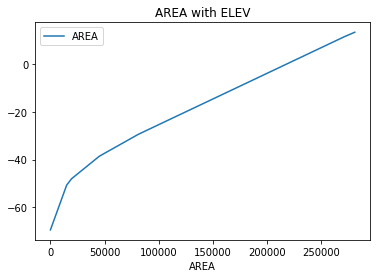

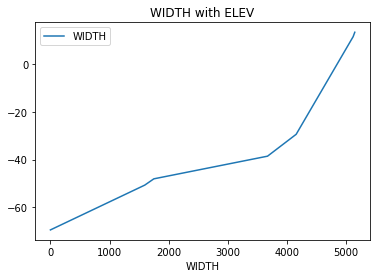

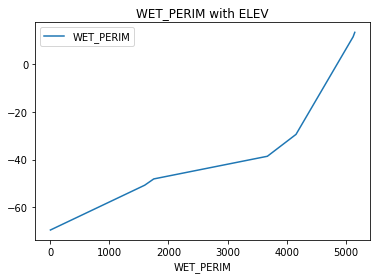

In [9]:
group=fc[fc.CHAN_NO==441].groupby('DIST')
dist,group=next(iter(group))
group.plot(y='ELEV',x='AREA',kind='line',label='AREA',title='AREA with ELEV')
group.plot(y='ELEV',x='WIDTH',kind='line',label='WIDTH',title='WIDTH with ELEV')
_=group.plot(y='ELEV',x='WET_PERIM',kind='line',label='WET_PERIM',title='WET_PERIM with ELEV')

# Writing input to file

Once the tables are manipulated using pandas DataFrame functions, these can be written to a file to be used as input to run DSM2 models

The code below shows 

In [10]:
write_input('../../tests/hydro_echo_historical_v82_copy.inp',tables)